<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import catboost as cb
# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from warnings import simplefilter

from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
pd.set_option('chained_assignment', None)

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Загрузим данные. В качестве индекса возьмем дату и отсортируем по дате. Получим временной ряд.

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Сейчас данные по количеству заказов за каждые десять минут. Сделаем ресемплирование данных по одному часу.

In [5]:
data = data.resample('1H').sum()

In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Всего получили 4416 строк после ресемплирования.

In [8]:
#Проверка на пропуски в данных
data.isna().sum()

num_orders    0
dtype: int64

Пропусков в данных не наблюдаем.

In [9]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Среднее количество заказов в час составляет 84, медиана 78. Разброс заказов довольно большой. Максимальное число заказов составило 462.

Построим динамику количества заказов и добавим скользящее среднее - среднее количество заказов за сутки.

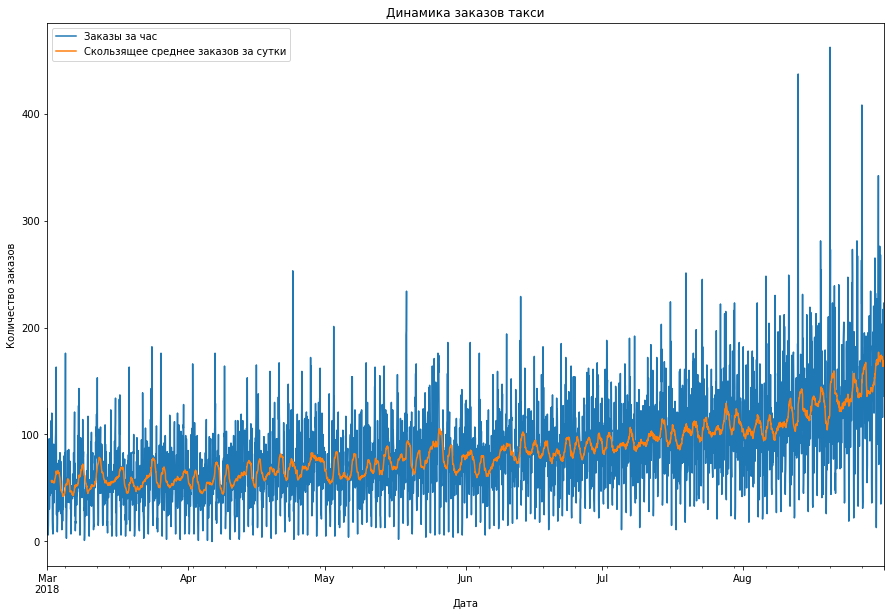

In [10]:
data['rolling_mean'] = data. rolling(24).mean()

data.plot(figsize = (15,10), title = 'Динамика заказов такси')
plt.xlabel("Дата");
plt.ylabel("Количество заказов")
plt.legend(['Заказы за час', 'Скользящее среднее заказов за сутки']);

В целом видим тенденцию к увеличению количества заказов и выраженнуб суточную сезонность.

In [11]:
data

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN
...,...,...
2018-08-31 19:00:00,136,167.541667
2018-08-31 20:00:00,154,168.041667
2018-08-31 21:00:00,159,166.416667


Выделим тренд, сезонную составляющую и остатки.

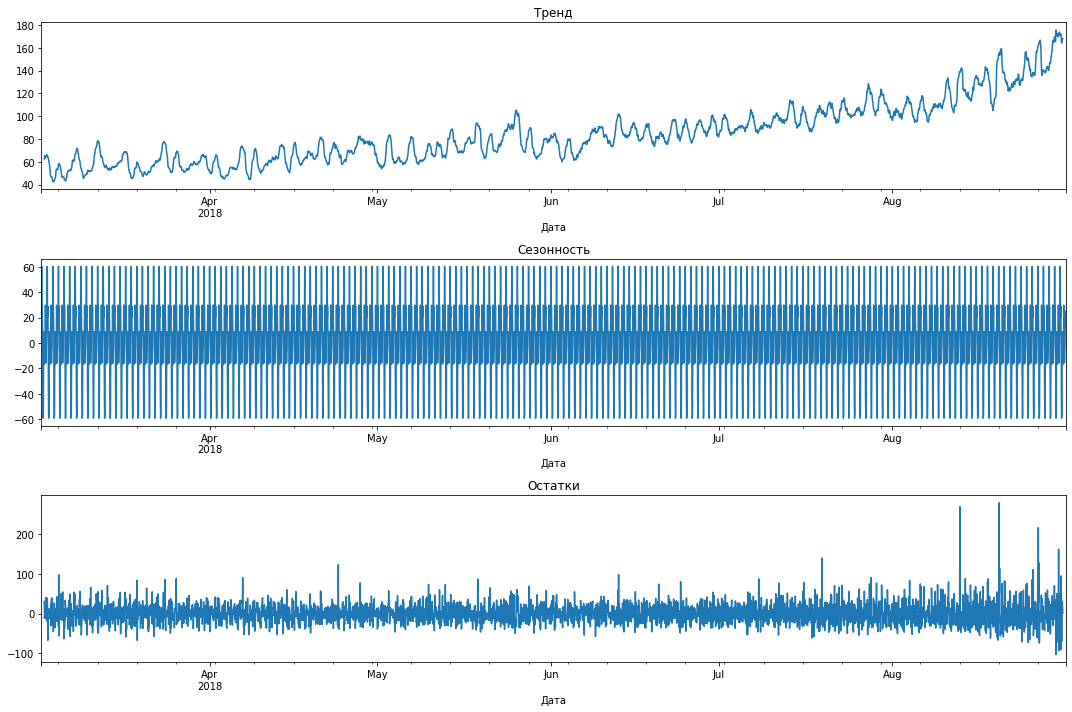

In [12]:
data = data.dropna()
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(15, 10))

plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.subplot(312)
decomposed. seasonal. plot(ax=plt.gca())
# < напишите код здесь >
plt.title('Сезонность')
plt.xlabel('Дата')
plt.subplot(313)
# < напишите код здесь >
decomposed. resid.plot(ax = plt.gca())
plt.title('Остатки')
plt.xlabel('Дата')
plt.tight_layout()

Тренд на увеличение числа заказов есть. Сезонность лучше посмотреть на более коротком отрезке времени. Закономерностей в остатках не выявлено.

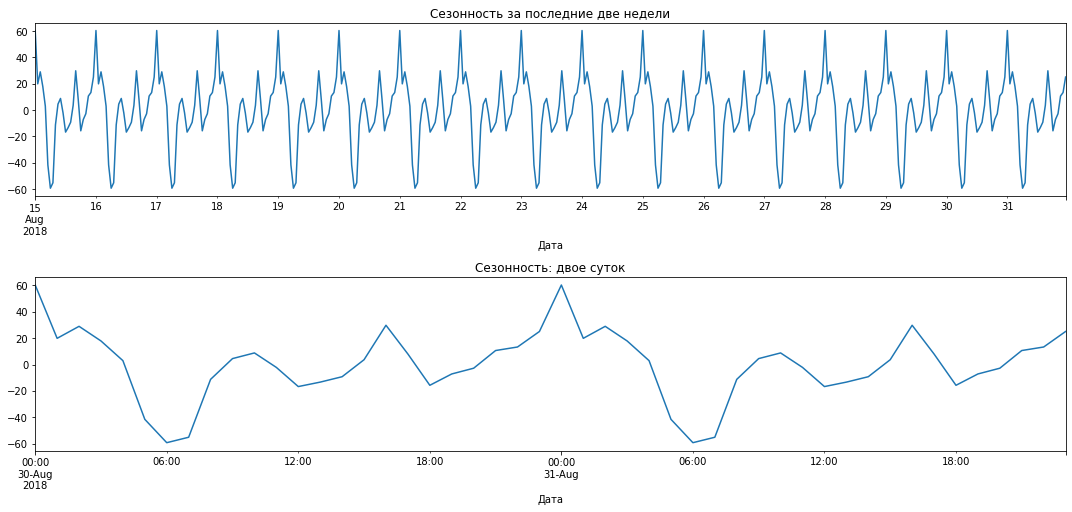

In [13]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.seasonal['2018-08-15':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность за последние две недели')
plt.xlabel('Дата')
plt.subplot(312)
decomposed.seasonal['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность: двое суток')
plt.xlabel('Дата')
plt.tight_layout()

Период сезонности  - сутки. Наибольший пик достигается в полночь. Затем количество заказов плавно снижается до 6 утра, где достигает минимума. А затем снова начинает расти.

## Обучение

In [14]:
# функция для создания допольнительных признаков:
# год, месяц, день, день недели
# lag_1,..,lag_max_lag - смещения значений, значения за предыдущий час, ..за час max_lag
def make_features(data, max_lag, rolling_mean_size):
    data_features = data.copy()
    data_features['year'] = data_features.index.year
    data_features['month'] = data_features.index.month
    data_features['day'] = data_features.index.day
    data_features['dayofweek'] = data_features.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_features['lag_{}'.format(lag)] = data_features['num_orders'].shift(lag)

    data_features['rolling_mean'] = data_features['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_features


Добавим в наши данные признаки:<br>
- год<br>
- месяц<br>
- день<br>
- день недели<br>
- данные за предыдущие часы (lag_1,..,lag_24)

In [15]:
data_features = make_features(data, 24, 24)

In [16]:
data_features.head(25)

,num_orders,rolling_mean,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 23:00:00,58,NaN,2018,3,1,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 00:00:00,90,NaN,2018,3,2,4,58.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 01:00:00,120,NaN,2018,3,2,4,90.0,58.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 02:00:00,75,NaN,2018,3,2,4,120.0,90.0,58.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 03:00:00,64,NaN,2018,3,2,4,75.0,120.0,90.0,58.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 04:00:00,20,NaN,2018,3,2,4,64.0,75.0,120.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 05:00:00,11,NaN,2018,3,2,4,20.0,64.0,75.0,120.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 06:00:00,11,NaN,2018,3,2,4,11.0,20.0,64.0,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 07:00:00,7,NaN,2018,3,2,4,11.0,11.0,20.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Добавим в качестве признака скользящее среднее заказов за неделю.

In [17]:
data_features['rolling_mean_week'] = data_features['num_orders'].shift().rolling(168).mean()

Разделим данные на тренировочные и тестовые. Размер тестовой выборки 10%.

In [18]:
train, test = train_test_split(data_features, shuffle=False, test_size=0.1)
train = train.dropna()
RANDOM_STATE = 42
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-08 23:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [19]:
X_train = train. drop(columns =['num_orders'] , axis =1)
y_train = train ['num_orders']
X_test = test. drop(columns = ['num_orders'], axis =1)
y_test = test['num_orders']

In [20]:
columns = X_train.columns

In [21]:
columns

Index(['rolling_mean', 'year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
       'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean_week'],
      dtype='object')

In [22]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe = Pipeline(
    [('simpleImputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
    )

data_preprocessor = ColumnTransformer(
     [('pipe', pipe, columns)
     ], 
    remainder='passthrough'
)


pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    #('select_k_best', SelectKBest(score_func=f_classif, k='all')),
    ('models', LinearRegression())
])
tscv = TimeSeriesSplit(n_splits=5)

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [LinearRegression(
                   
                  )] 
    },
    # словарь для модели DecisionTreeRegressor
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None, 10, 20, 30],
        'models__min_samples_split': [2, 10, 20],
        'models__min_samples_leaf': [1, 5, 10]
    },
    # словарь для модели LGBMRegressor()
    {
        'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'models__num_leaves': [31, 50],
        'models__learning_rate': [0.05, 0.1],
        'models__n_estimators': [100, 200]
    },
    # словарь для модели CatBoostRegressor
    {
        'models': [cb.CatBoostRegressor(random_state=RANDOM_STATE, silent=True)],
        'models__depth': [3, 5, 7],
        'models__learning_rate': [0.05, 0.1],
        'models__iterations': [100, 200]
    },
    # словарь для модели GradientBoostingRegressor
    {
        'models': [GradientBoostingRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200],
        'models__learning_rate': [0.05, 0.1],
        'models__max_depth': [3, 5]
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv = tscv,#для временных рядов используем TimeSeriesSplit
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', -randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipe',
                                                  Pipeline(steps=[('simpleImputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['rolling_mean', 'year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
       'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean_week'],
      dtype='object'))])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x7fc944e14100>)])
Метрика лучшей модели на тренировочной выборке: 26.52204790798111


In [23]:
result = pd.DataFrame(randomized_search.cv_results_)
pd.set_option('display.max_colwidth', None)
display(result[
   ['rank_test_score', 'param_models', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
].sort_values('rank_test_score'))

,rank_test_score,param_models,mean_test_score,mean_fit_time,mean_score_time,params
0,1,<catboost.core.CatBoostRegressor object at 0x7fc944d969a0>,-26.522048,1.554079,0.005650,"{'models__learning_rate': 0.05, 'models__iterations': 100, 'models__depth': 7, 'models': <catboost.core.CatBoostRegressor object at 0x7fc944d969a0>}"
1,2,GradientBoostingRegressor(random_state=42),-26.572280,3.004223,0.008243,"{'models__n_estimators': 200, 'models__max_depth': 5, 'models__learning_rate': 0.05, 'models': GradientBoostingRegressor(random_state=42)}"
8,3,GradientBoostingRegressor(random_state=42),-26.809660,3.054994,0.007160,"{'models__n_estimators': 200, 'models__max_depth': 5, 'models__learning_rate': 0.1, 'models': GradientBoostingRegressor(random_state=42)}"
5,4,GradientBoostingRegressor(random_state=42),-26.873537,0.940663,0.005747,"{'models__n_estimators': 100, 'models__max_depth': 3, 'models__learning_rate': 0.1, 'models': GradientBoostingRegressor(random_state=42)}"
2,5,LinearRegression(),-27.290052,0.182176,0.091712,{'models': LinearRegression()}
3,6,<catboost.core.CatBoostRegressor object at 0x7fc944d969a0>,-27.463815,1.321949,0.005223,"{'models__learning_rate': 0.05, 'models__iterations': 100, 'models__depth': 3, 'models': <catboost.core.CatBoostRegressor object at 0x7fc944d969a0>}"
6,7,DecisionTreeRegressor(random_state=42),-30.765013,0.042304,0.004674,"{'models__min_samples_split': 2, 'models__min_samples_leaf': 10, 'models__max_depth': 10, 'models': DecisionTreeRegressor(random_state=42)}"
7,8,DecisionTreeRegressor(random_state=42),-32.050026,0.044334,0.004820,"{'models__min_samples_split': 20, 'models__min_samples_leaf': 1, 'models__max_depth': 10, 'models': DecisionTreeRegressor(random_state=42)}"
9,9,DecisionTreeRegressor(random_state=42),-32.954139,0.049497,0.004346,"{'models__min_samples_split': 20, 'models__min_samples_leaf': 1, 'models__max_depth': 30, 'models': DecisionTreeRegressor(random_state=42)}"
4,10,DecisionTreeRegressor(random_state=42),-33.259061,0.049314,0.004333,"{'models__min_samples_split': 10, 'models__min_samples_leaf': 5, 'models__max_depth': None, 'models': DecisionTreeRegressor(random_state=42)}"


Для построения прогноза были применены несколько моделей:<br>
    - LinearRegression<br>
    - DecisionTreeRegressor<br>
    - LGBMRegressor<br>
    - CatBoostRegressor<br>
    - GradientBoostingRegressor<br>
Они оценивались метрикой качества RMSE.<br>
Лучше всего метрику дала модель градиентного бустинга **CatBoostRegressor** со следующими параметрами:<br>
    - max_depth: 7<br>
    - iterations: 100<br>
    - learning_rate: 0.05<br>
Значение метрики RMSE на тренировочной выборке составило 26,52.<br>

В таблице сравнения моделей также рассмотрели два столбца:<br>
    - mean_fit_time: время обучения<br>
    - mean_score_time: время предсказания<br>
Модель градиентного бустинга **CatBoostRegressor** дает следующие результаты по времени обучения 1.43 и времени предсказания 0.005.

## Тестирование

In [24]:
pred = randomized_search.predict(X_test)
print(f'Метрика на тестовой выборке: {mean_squared_error(pred, y_test, squared=False)}')

Метрика на тестовой выборке: 45.992804462784854


In [25]:
y_test

datetime
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
2018-08-13 19:00:00     91
2018-08-13 20:00:00     82
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 440, dtype: int64

In [26]:
test_preds = pd.Series(pred.tolist(), index = y_test.index)

In [27]:
data_pred = pd.DataFrame(y_test)
data_pred['pred'] = test_preds


In [28]:
data_pred = data_pred.tail(168)

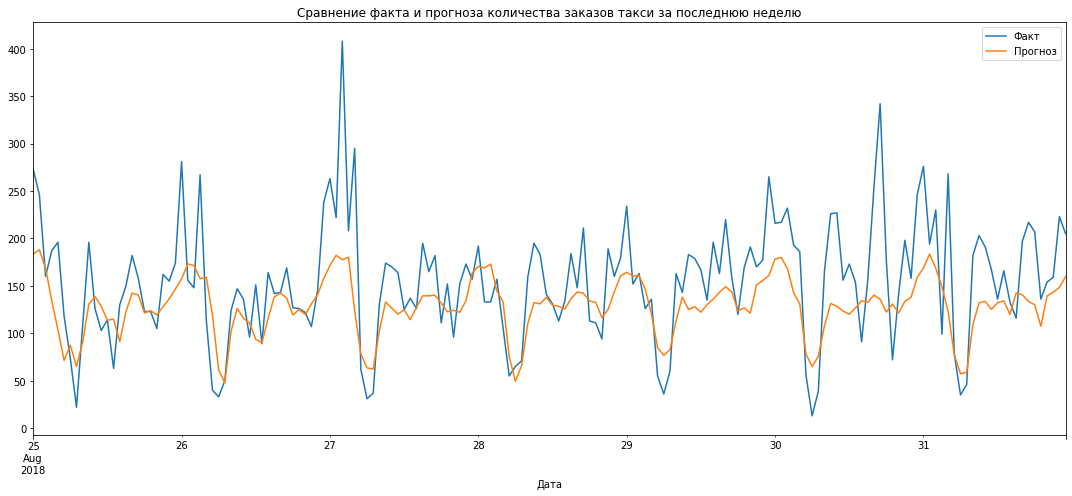

In [29]:
plt.figure(figsize=(15, 7))
data_pred.plot(ax=plt.gca())
plt.title('Сравнение факта и прогноза количества заказов такси за последнюю неделю')
plt.xlabel('Дата')
plt.legend(['Факт', 'Прогноз']);
plt.tight_layout()

### Выводы
Целью задачи было спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. Заказчиком выступила компания «Чётенькое такси».<br>

**Данные** были загружены, преобразованы во временной ряд и ресемплированы.<br>
Получили 4416 строк - данные о количестве заказов за каждый час.<br>

Разделили ряд на составляющие:<br>
- тренд<br>
- сезонная компонента<br>
- остатки<br>

**Тренд** на увеличение числа заказов есть. Закономерностей в остатках не выявлено.<br>
**Сезонность** посмотрели на более коротком отрезке времени. <br>
Период сезонности - сутки. Наибольший пик достигается в полночь. Затем количество заказов плавно снижается до 6 утра, где достигает минимума. А затем снова начинает расти.<br>

Добавим в наши данные **признаки**:<br>
- год<br>
- месяц<br>
- день<br>
- день недели<br>
- данные за предыдущие часы (lag_1,..,lag_24)<br>
- скользящее среднее за сутки и за неделю<br>

**Для построения прогноза** были применены несколько моделей:<br>
    - LinearRegression<br>
    - DecisionTreeRegressor<br>
    - LGBMRegressor<br>
    - CatBoostRegressor<br>
    - GradientBoostingRegressor<br>
Они оценивались метрикой качества RMSE.<br>
Лучше всего метрику дала модель градиентного бустинга **CatBoostRegressor** со следующими параметрами:<br>
    - max_depth: 7<br>
    - iterations: 100<br>
    - learning_rate: 0.05<br>
Значение метрики RMSE на тренировочной выборке составило 26,52.<br>

На **тестовой выборке** получили значение метрики 45.99. Построили график сравнения факт/прогноз.<br>

В целом дополнительное привлечение такистов целесообразно в пиковые дневные часы и в полночь. Можно ориентироваться на предсказанное число заказов такси.<br>
В модель также можно добавить признак - праздничные дни.
